In [302]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import *
from dateutil.relativedelta import relativedelta

import itertools


## Data import

Two datasets are created: wikiData_all and protections_all. Both of them are result of concatenation of three tables - one for each topic.

In [303]:
wikiData_US = pd.read_csv("../data/detailed_data/detailedEdits_2024-06-13-11-03.csv")
wikiData_US['topic'] = 'US_Civil_War'
wikiData_UA = pd.read_csv("../data/detailed_data/detailedEdits_2024-06-13-22-44.csv")
wikiData_UA['topic'] = 'Ukraine'
wikiData_IP = pd.read_csv("../data/detailed_data/detailedEdits_2024-06-14-11-41.csv")
wikiData_IP['topic'] = 'Israel/Palestine'

wikiData_all = pd.concat([wikiData_UA, wikiData_US, wikiData_IP])[['user', 'timestamp', 'size', 'reverted', 'reversion', 'topic', 'article', 'language', 'total_edits', 'article_edits']].drop_duplicates()
wikiData_all['ratio_edits'] = (wikiData_all['article_edits']/wikiData_all['total_edits']).replace(np.inf, 1.01) # IP address users miss total_edit parameter, likely have been editing a single article only

wikiData_all['timestamp'] = pd.to_datetime(wikiData_all['timestamp'])
wikiData_all['month'] = wikiData_all['timestamp'].dt.month
wikiData_all['year'] = wikiData_all['timestamp'].dt.year

protections_US = pd.read_csv("../data/protection_data/protections_Us_civil_war_2024-06-15-19-46.csv")
protections_US['topic'] = 'US_Civil_War'
protections_UA = pd.read_csv("../data/protection_data/protections_Ukraine_2024-06-15-21-39.csv")
protections_UA['topic'] = 'Ukraine'
protections_IP = pd.read_csv("../data/protection_data/protections_Israel_Palestine_2024-06-15-19-44.csv")
protections_IP['topic'] = 'Israel/Palestine'

protections_all = pd.concat([protections_US, protections_UA, protections_IP]).drop_duplicates()
protections_all['timestamp'] = pd.to_datetime(protections_all['timestamp'])


## Data cleaning

In this part, we deal with cases where the action is "unprotect" and with NaN values. Result is column "expiry_mod" which displays the actual expiry of the protection (or our best guess of it).

In [304]:
protections_clean_pm = protections_all[(protections_all['action'] != 'unprotect')].sort_values(['article', 'language', 'timestamp'], ascending=[True, True, True]) # & (protections_all['action'] != 'move_prot')
protections_clean_u = protections_all[protections_all['action'] == 'unprotect']

protections_clean_pm['expiry_mod'] = protections_clean_pm['expiry'].fillna(datetime(2029,12,31))
protections_clean_pm = protections_clean_pm.reset_index()

for index, row in protections_clean_pm.iterrows():

    protections_clean_u_al = protections_clean_u[(protections_clean_u['article'] == row['article']) & (protections_clean_u['language'] == row['language'])]
    protections_clean_u_al = protections_clean_u_al[(protections_clean_u_al['timestamp'] > row['timestamp']) & (protections_clean_u_al['timestamp'] < row['expiry_mod'])]
              

    if len(protections_clean_u_al) > 0:
        
        protections_clean_pm.at[index, 'expiry_mod'] = protections_clean_u_al['timestamp'].min()

protections_cleaned = protections_clean_pm[['article', 'language', 'timestamp', 'expiry', 'expiry_mod', 'user', 'type']].sort_values(['article', 'language', 'timestamp'], ascending=[True, True, True], ignore_index=True)
protections_cleaned

,article,language,timestamp,expiry,expiry_mod,user,type
0,1929_Hebron_massacre,en,2007-04-16 16:23:53,2007-04-23 16:23:00,2007-04-23 16:23:00,Thatcher,NaN
1,1929_Hebron_massacre,en,2007-04-16 16:34:27,2007-04-19 16:34:00,2007-04-19 16:34:00,Thatcher,NaN
2,1929_Hebron_massacre,en,2007-10-16 20:55:51,2007-10-23 20:55:00,2007-10-23 20:55:00,Penwhale,NaN
3,1929_Hebron_massacre,en,2014-07-24 20:00:31,2014-08-07 20:00:00,2014-08-07 20:00:00,NawlinWiki,NaN
4,1929_Hebron_massacre,en,2019-04-29 20:40:37,2029-12-31 23:59:59,2029-12-31 23:59:59,Oshwah,"['edit', 'move']"
...,...,...,...,...,...,...,...
1079,Zaporozhian_Cossacks,ru,2022-04-25 19:17:52,2022-05-02 19:17:00,2022-05-02 19:17:00,QBA-bot,"['edit', 'move']"
1080,Zaporozhian_Cossacks,ru,2023-09-27 11:06:22,2023-10-04 11:06:00,2023-10-04 11:06:00,QBA-bot,"['edit', 'move']"
1081,Ze'ev_Jabotinsky,en,2019-11-30 00:27:08,2019-12-30 00:27:00,2019-12-30 00:27:00,Berean Hunter,['edit']
1082,Ze'ev_Jabotinsky,en,2024-05-02 09:42:26,2024-06-02 09:42:00,2024-05-02 19:34:55,Doug Weller,"['edit', 'move']"


In [305]:
protections_cleaned['expiry_mod_mod'] = protections_cleaned['expiry_mod']

for index, row in protections_cleaned.iterrows():
    protections_a_l = protections_cleaned[(protections_cleaned['article'] == row['article']) & (protections_cleaned['language'] == row['language'])]
    protections_a_l = protections_a_l[(protections_a_l['timestamp'] > row['timestamp'])]
    
    #if pd.isna(row['type']):
    #    protections_a_l = protections_a_l[pd.isna(protections_a_l['type'])]
    #else:
    #    protections_a_l = protections_a_l[protections_a_l['type'] == row['type']]
    
            
    try:
        protections_a_l = protections_a_l[(protections_a_l['timestamp'] < row['expiry_mod'])]

      
        if len(protections_a_l) > 0:

            protections_cleaned.at[index, 'expiry_mod_mod'] = protections_a_l['timestamp'].min()
        
            
    
    except:
        
        continue


protections_cleaned['expiry_mod'] = pd.to_datetime(protections_cleaned['expiry_mod'])
protections_cleaned['expiry_mod_mod'] = pd.to_datetime(protections_cleaned['expiry_mod_mod'])

Cleaning and aggregating wikiData_all is done in same way like in correlation_analysis notebook

In [307]:
wikiData_grouped = wikiData_all.groupby(['topic', 'article', 'language', 'year', 'month']).agg(
    edits = ('timestamp', 'size'),
    reverted_edits = ('reverted', 'sum'),
    reversions = ('reversion', 'sum'),
    mean_size = ('size', 'mean')
).reset_index()

first_edits = wikiData_all.groupby(['article', 'language'])['timestamp'].min().reset_index().rename(columns={'timestamp': 'first_edit'})

wikiData_grouped = wikiData_grouped.merge(first_edits, on=['article', 'language'])

wikiData_grouped


,topic,article,language,year,month,edits,reverted_edits,reversions,mean_size,first_edit
0,Israel/Palestine,1929_Hebron_massacre,ar,2007,7,6,0,0,725.833333,2007-07-19 13:55:39
1,Israel/Palestine,1929_Hebron_massacre,ar,2007,8,1,0,0,916.000000,2007-07-19 13:55:39
2,Israel/Palestine,1929_Hebron_massacre,ar,2007,10,5,0,0,4190.000000,2007-07-19 13:55:39
3,Israel/Palestine,1929_Hebron_massacre,ar,2007,12,2,0,0,5977.500000,2007-07-19 13:55:39
4,Israel/Palestine,1929_Hebron_massacre,ar,2008,1,1,0,0,5838.000000,2007-07-19 13:55:39
...,...,...,...,...,...,...,...,...,...,...
55614,Ukraine,Zaporozhian_Cossacks,uk,2022,3,2,0,0,20818.000000,2008-04-29 14:22:24
55615,Ukraine,Zaporozhian_Cossacks,uk,2023,3,1,0,0,20918.000000,2008-04-29 14:22:24
55616,Ukraine,Zaporozhian_Cossacks,uk,2023,4,1,0,0,20918.000000,2008-04-29 14:22:24
55617,Ukraine,Zaporozhian_Cossacks,uk,2023,8,1,0,0,21295.000000,2008-04-29 14:22:24


In [308]:
def insert_empty_intervals(df, oldest = datetime(2005,1,1)):


    articles = df['article'].unique()
    langs = df['language'].unique()
    years = df['year'].sort_values(ascending = True).unique()
    months = df['month'].sort_values(ascending = True).unique()

    cartesian_product = list(itertools.product(articles, langs, years, months))

    df_cartesian_product = pd.DataFrame(cartesian_product, columns=['article', 'language', 'year', 'month'])
    

    result_df = pd.merge(df_cartesian_product, df, how = 'left', on = ['article', 'language', 'year', 'month'])
    

    result_df = result_df.drop(columns = ['first_edit', 'topic'], errors='ignore')
    result_df = result_df.merge(first_edits, on=['article', 'language'], how='left')
    result_df = result_df.merge(df[['topic', 'article']].drop_duplicates(), on = 'article', how='left')    

    result_df['edits'] = result_df['edits'].fillna(0)
    result_df['reverted_edits'] = result_df['reverted_edits'].fillna(0)
    result_df['reversions'] = result_df['reversions'].fillna(0)

    result_df = result_df[result_df['year'] >= oldest.year]
    result_df = result_df[result_df['year'] >= result_df['first_edit'].dt.year]
    result_df = result_df[(result_df['year'] > result_df['first_edit'].dt.year) | (result_df['month'] >= result_df['first_edit'].dt.month)]

    grouped = result_df.groupby(['article', 'language']).agg(
        total_edits = ('edits', 'sum'),
        total_reversions = ('reversions', 'sum'),
        total_reverted = ('reverted_edits', 'sum')
    ).reset_index()

    result_df = pd.merge(result_df, grouped, on=['article', 'language'], how='left')

    grouped2 = result_df[(result_df['year'] > 2020) | ((result_df['year'] == 2020) & (result_df['month'] > 8))].groupby(['article', 'language']).agg(
        total_edits = ('edits', 'sum'),
        total_reversions = ('reversions', 'sum'),
        total_reverted = ('reverted_edits', 'sum')
    ).reset_index()

    result_df = pd.merge(result_df, grouped2, on=['article', 'language'], how='left', suffixes=['', '_after_aug2020'])
    result_df['date'] = pd.to_datetime(result_df[['year', 'month']].assign(day=1))



    return result_df[
        ['topic', 'article', 'language', 'date', 'edits', 'reverted_edits', 'reversions', 'mean_size', 'first_edit', 'total_edits', 'total_reversions', 'total_reverted', 'total_edits_after_aug2020', 'total_reversions_after_aug2020', 'total_reverted_after_aug2020']
    ].sort_values('date')


wikiData = insert_empty_intervals(wikiData_grouped)
wikiData

,topic,article,language,date,edits,reverted_edits,reversions,mean_size,first_edit,total_edits,total_reversions,total_reverted,total_edits_after_aug2020,total_reversions_after_aug2020,total_reverted_after_aug2020
57115,Ukraine,Kyiv,en,2005-01-01,31.0,0.0,0.0,24598.129032,2002-02-24 10:22:32,5677.0,140.0,88.0,889.0,67.0,88.0
24367,Israel/Palestine,Yom_Kippur_War,ar,2005-01-01,0.0,0.0,0.0,NaN,2004-06-24 19:43:36,3852.0,71.0,113.0,416.0,66.0,113.0
58074,Ukraine,Kyiv_Pechersk_Lavra,en,2005-01-01,3.0,0.0,0.0,890.333333,2004-02-20 21:37:43,825.0,52.0,35.0,193.0,17.0,35.0
32121,US_Civil_War,James_Longstreet,en,2005-01-01,6.0,0.0,0.0,9716.333333,2002-04-18 13:37:00,3360.0,88.0,89.0,1054.0,57.0,89.0
69482,Ukraine,Rusyns,en,2005-01-01,3.0,0.0,0.0,5862.000000,2004-05-21 11:55:36,1885.0,53.0,32.0,366.0,24.0,32.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19408,Israel/Palestine,Plan_Dalet,de,2024-12-01,0.0,0.0,0.0,NaN,2011-02-19 15:40:19,31.0,0.0,0.0,12.0,0.0,0.0
19241,Israel/Palestine,Plan_Dalet,ar,2024-12-01,0.0,0.0,0.0,NaN,2005-01-01 01:18:47,138.0,0.0,0.0,60.0,0.0,0.0
82228,Ukraine,Zaporozhian_Cossacks,en,2024-12-01,0.0,0.0,0.0,NaN,2004-06-22 10:32:36,926.0,33.0,19.0,113.0,12.0,19.0
67456,Ukraine,Pierogi,ru,2024-12-01,0.0,0.0,0.0,NaN,2019-12-17 14:35:54,90.0,14.0,14.0,47.0,13.0,14.0


## Aggregations

In this part we aim to aggregate by year/topic/language in order to compare the topics / language versions with each other and see the evolution in time.

In [309]:
agg_cols = wikiData[['topic', 'article', 'language', 'date', 'edits']].drop_duplicates().sort_values(['topic', 'article', 'language', 'date'])
agg_cols = agg_cols.reset_index().drop(columns='index')
agg_cols

,topic,article,language,date,edits
0,Israel/Palestine,1929_Hebron_massacre,ar,2007-07-01,6.0
1,Israel/Palestine,1929_Hebron_massacre,ar,2007-08-01,1.0
2,Israel/Palestine,1929_Hebron_massacre,ar,2007-09-01,0.0
3,Israel/Palestine,1929_Hebron_massacre,ar,2007-10-01,5.0
4,Israel/Palestine,1929_Hebron_massacre,ar,2007-11-01,0.0
...,...,...,...,...,...
82651,Ukraine,Zaporozhian_Cossacks,uk,2024-08-01,0.0
82652,Ukraine,Zaporozhian_Cossacks,uk,2024-09-01,0.0
82653,Ukraine,Zaporozhian_Cossacks,uk,2024-10-01,0.0
82654,Ukraine,Zaporozhian_Cossacks,uk,2024-11-01,0.0


In [310]:
agg_cols['protected_time'] = 0
agg_cols['protected_proportion'] = 0


for index, row in agg_cols.iterrows():

    protections_a_l = protections_cleaned[(protections_cleaned['article'] == row['article']) & (protections_cleaned['language'] == row['language'])]
    protections_a_l = protections_a_l[protections_a_l['timestamp'] <= row['date'] + relativedelta(months=+1)]
    protections_a_l = protections_a_l[protections_a_l['expiry_mod_mod'] >= row['date']]

    if len(protections_a_l) > 0:

        next_month = row['date'] + relativedelta(months=+1)
        protections_a_l['start'] = protections_a_l['timestamp'].apply(lambda x: row['date'] if x < row['date'] else x)
        protections_a_l['end'] = protections_a_l['expiry_mod_mod'].apply(lambda x: next_month if x > next_month else x)

        protections_a_l['length'] = (protections_a_l['end'] - protections_a_l['start']).dt.total_seconds() / (3600 * 24)
      
        total_time = (next_month - row['date']).total_seconds() / (3600 * 24)
        
        agg_cols.at[index, 'protected_time'] = sum(protections_a_l['length'])
        agg_cols.at[index, 'protected_proportion'] = sum(protections_a_l['length']) / total_time

In [311]:
agg_cols

,topic,article,language,date,edits,protected_time,protected_proportion
0,Israel/Palestine,1929_Hebron_massacre,ar,2007-07-01,6.0,0.0,0.0
1,Israel/Palestine,1929_Hebron_massacre,ar,2007-08-01,1.0,0.0,0.0
2,Israel/Palestine,1929_Hebron_massacre,ar,2007-09-01,0.0,0.0,0.0
3,Israel/Palestine,1929_Hebron_massacre,ar,2007-10-01,5.0,0.0,0.0
4,Israel/Palestine,1929_Hebron_massacre,ar,2007-11-01,0.0,0.0,0.0
...,...,...,...,...,...,...,...
82651,Ukraine,Zaporozhian_Cossacks,uk,2024-08-01,0.0,0.0,0.0
82652,Ukraine,Zaporozhian_Cossacks,uk,2024-09-01,0.0,0.0,0.0
82653,Ukraine,Zaporozhian_Cossacks,uk,2024-10-01,0.0,0.0,0.0
82654,Ukraine,Zaporozhian_Cossacks,uk,2024-11-01,0.0,0.0,0.0


## Plots

In [433]:
def aggregate_filter_protection(langs : list = None, topic : str = None, articles : list = None, length_protection : str = None, timestart : datetime = None, timestop : datetime = None, protections_df : pd.DataFrame = agg_cols, group_by : str = None, agg_col : str = "protected_proportion"):

    filtered_df = protections_df

    if langs is not None:
        filtered_df = filtered_df[filtered_df['language'].isin(langs)]
    if topic is not None:
        filtered_df = filtered_df[filtered_df['topic'] == topic]
    if length_protection is not None:
        filtered_df = filtered_df[filtered_df['length_protection'] == length_protection]
    if articles is not None:
        filtered_df = filtered_df[filtered_df['article'].isin(articles)]
    if timestart is not None:
        filtered_df = filtered_df[filtered_df['date'] >= timestart]
    if timestop is not None:
        filtered_df = filtered_df[filtered_df['date'] <= timestop]
    
    group_list = ['date']
    if group_by is not None:
        group_list.append(group_by)
    
    if agg_col == "protected_proportion":
        filtered_df = filtered_df.groupby(group_list).agg(
            protected_proportion = ('protected_proportion', 'mean')
        ).reset_index()
    elif agg_col == 'length_protection':
        filtered_df = filtered_df.groupby(group_list).agg(
            count = ('count', 'sum')
        ).reset_index()

    return filtered_df

def plot_protection(langs : list = None, topic : str = None, articles : list = None, length_protection : str = None, timestart : datetime = None, timestop : datetime = None, protections_df : pd.DataFrame = agg_cols, group_by : str = None, agg_col : str = "protected_proportion"):

    plot_df = aggregate_filter_protection(langs,topic, articles, length_protection, timestart, timestop, protections_df, group_by, agg_col)

    plt.figure(figsize=(20, 10))
    
    if agg_col == 'length_protection':
        agg_col = 'count'
        
    if plot_df.shape[1] == 3:

        third_column = [c for c in list(plot_df.columns) if c not in ['date', agg_col]][0]
        for unique_value in plot_df[third_column].unique():
            fplot_df = plot_df[plot_df[third_column] == unique_value]
            plt.plot(fplot_df['date'], fplot_df[agg_col], marker='.', linestyle='-', label = unique_value)
        plt.legend(title='Categories')
    
    elif plot_df.shape[1] == 2:
        plt.plot(plot_df['date'], plot_df[agg_col], marker='o', linestyle='-')
    
    else:
        return
    
    plt.xlabel('Date')
    plt.ylabel('Protection score')
    plt.title('Protection score over time')
    
    plt.grid(True)
    plt.show()

    


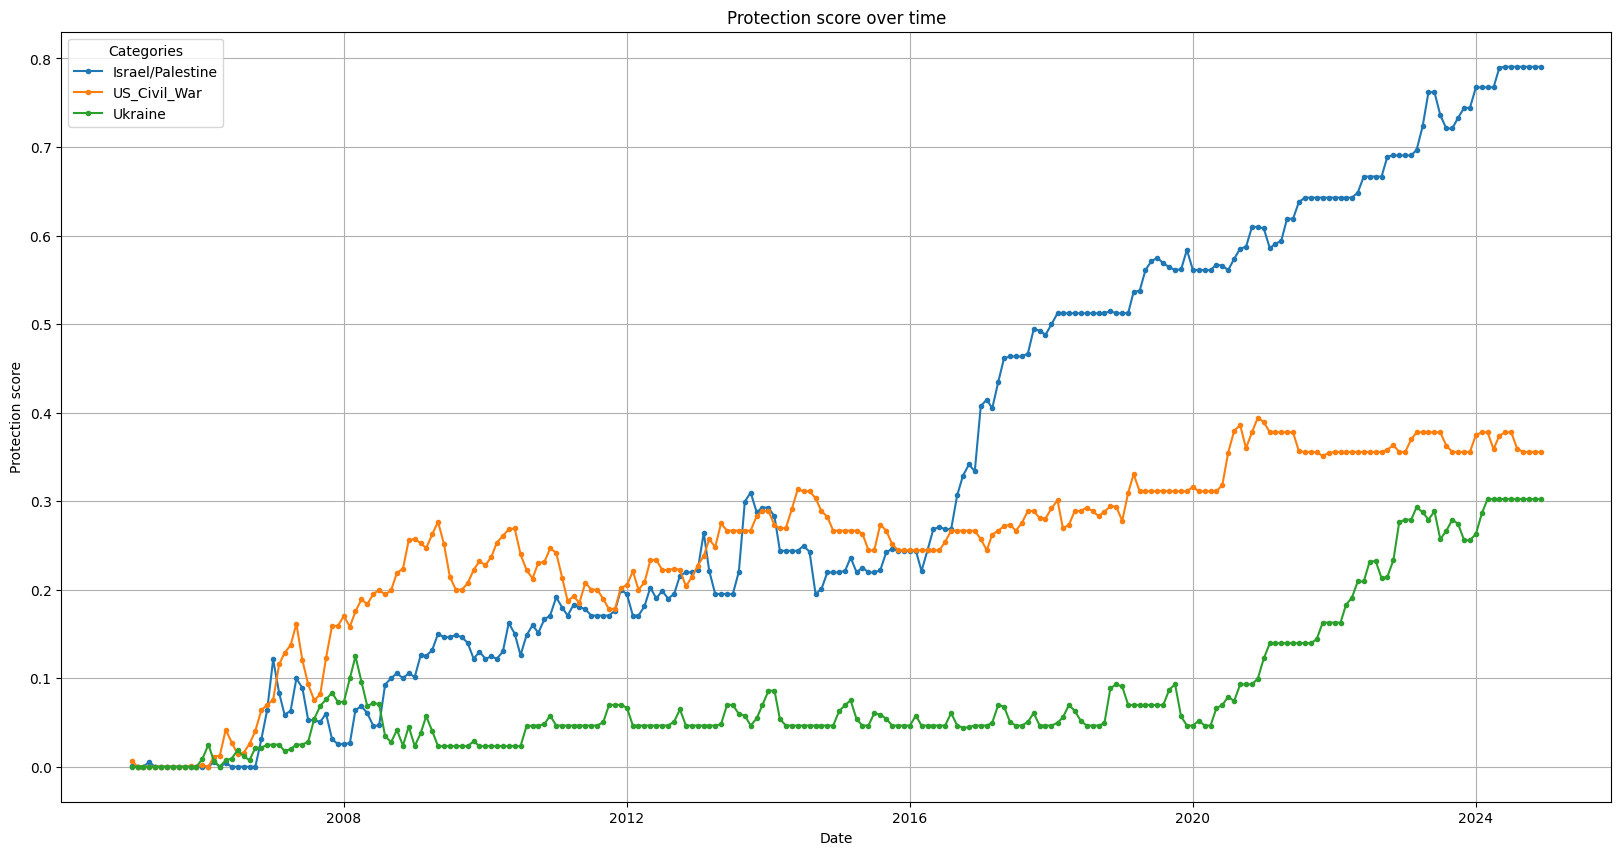

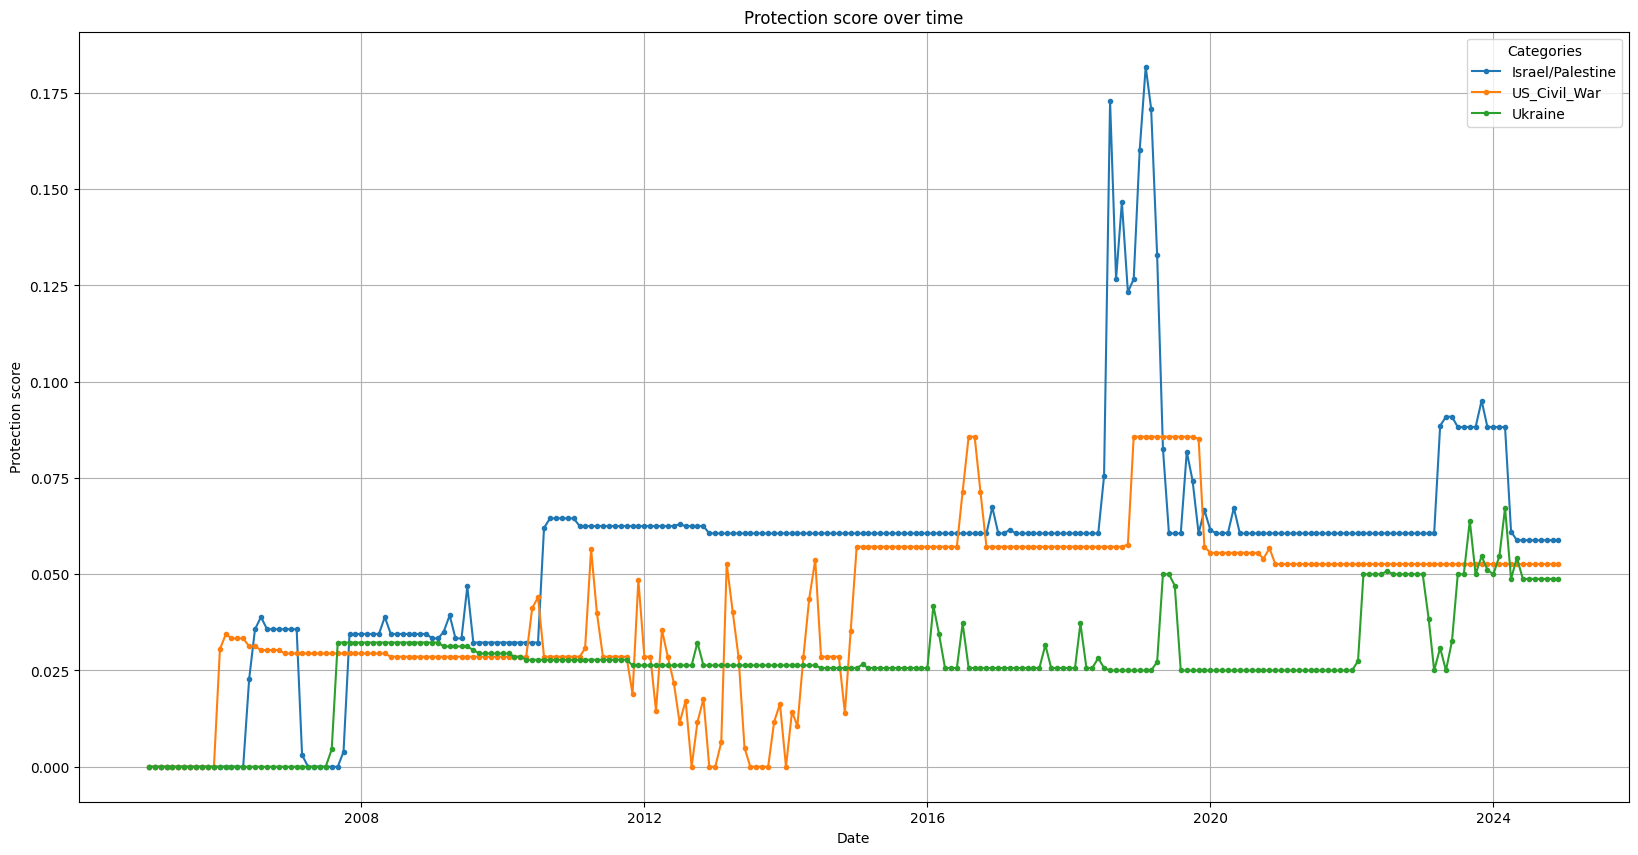

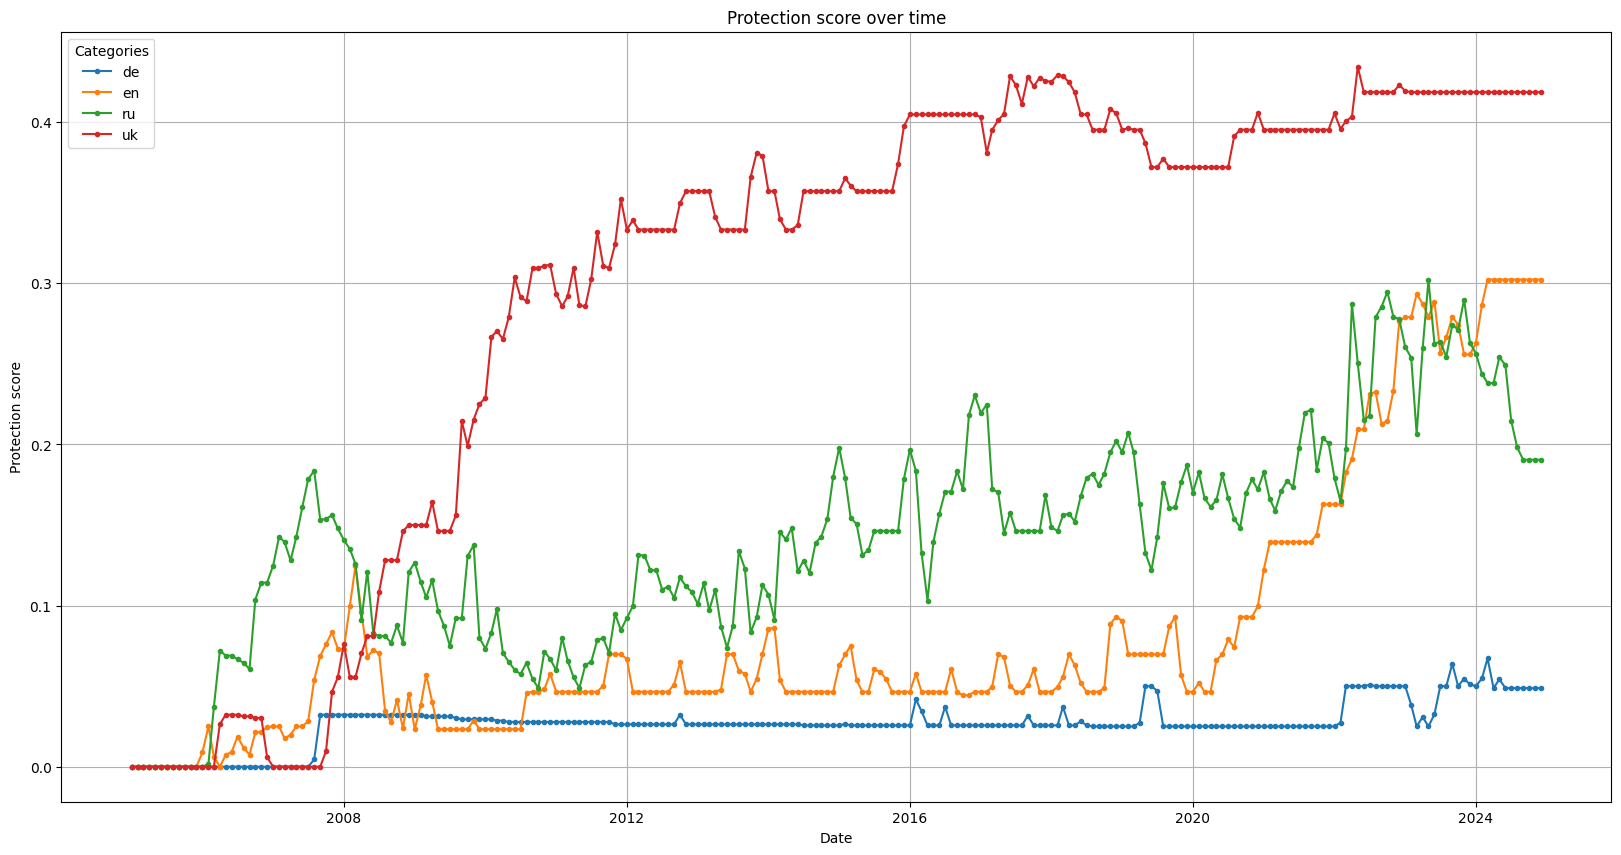

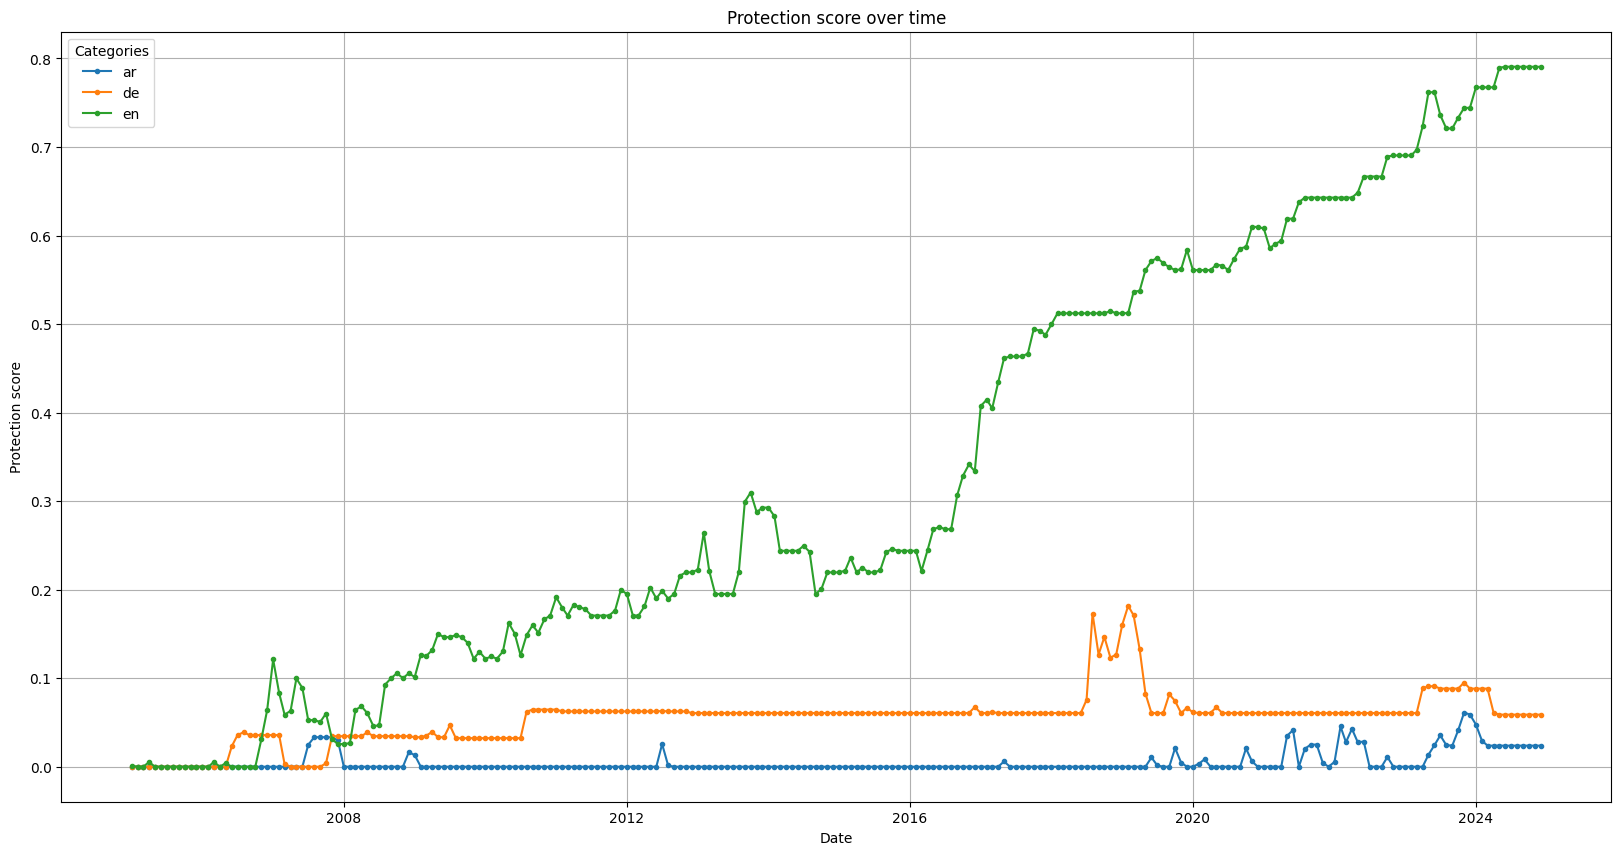

In [395]:
plot_protection(langs=['en'], group_by = 'topic')
plot_protection(langs=['de'], group_by = 'topic')
plot_protection(topic = 'Ukraine', group_by = 'language')
plot_protection(topic = 'Israel/Palestine', group_by = 'language')

## Length of protections

In [413]:
protections_lengths = protections_all
protections_lengths['timestamp'] = pd.to_datetime(protections_lengths['timestamp'])
protections_lengths['expiry'] = pd.to_datetime(protections_lengths['expiry'])

def protection_length_fun(row):

    if row['action'] == "unprotect":

        return 'Unprotect'
    
    if pd.isna(row['expiry']):

        return 'NA expiry'
    
    if (row['expiry'] - row['timestamp']).total_seconds() / (3600 * 24) <= 30:

        return 'Short'
    
    if (row['expiry'] - row['timestamp']).total_seconds() / (3600 * 24) <= 180:

        return 'Medium'
    
    return 'Long'

protections_lengths['length_protection'] = protections_lengths.apply(protection_length_fun, axis=1)
protections_lengths['date'] = protections_lengths['timestamp'].apply(lambda x: x.replace(month=1, day=1, hour=0, minute=0, second=0))

protections_lengths


,Unnamed: 0,language,title,timestamp,user,action,comment,type,level,expiry,article,topic,Length_protection,length_protection,date
0,0,en,Ulysses S. Grant,2010-10-20 18:55:00,Just Step Sideways,modify,removing PC protection and re-instating previo...,NaN,NaN,2029-12-31 23:59:59,Ulysses_S._Grant,US_Civil_War,Long,Long,2010-01-01
1,1,en,Ulysses S. Grant,2010-06-19 16:08:15,Risker,modify,[[Wikipedia:Pending changes]] trial,NaN,NaN,2029-12-31 23:59:59,Ulysses_S._Grant,US_Civil_War,Long,Long,2010-01-01
2,2,en,Ulysses S. Grant,2010-02-24 08:51:01,Graham87,move_prot,[[MediaWiki talk:Ulysses S. Grant]] moved to [...,NaN,NaN,NaT,Ulysses_S._Grant,US_Civil_War,NA expiry,NA expiry,2010-01-01
3,3,en,Ulysses S. Grant,2008-10-11 18:22:18,NawlinWiki,modify,[[WP:MOVP|Page-move vandalism]],NaN,NaN,2029-12-31 23:59:59,Ulysses_S._Grant,US_Civil_War,Long,Long,2008-01-01
4,4,en,Ulysses S. Grant,2008-10-11 09:41:31,Luk,protect,moved [[.H....A....Ġ....Ġ....E....R ?]] to [[U...,NaN,NaN,NaT,Ulysses_S._Grant,US_Civil_War,NA expiry,NA expiry,2008-01-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
282,282,en,Palestinian cuisine,2016-06-08 02:25:24,Elockid,protect,Persistent [[WP:Sock puppetry|sock puppetry]],"['edit', 'move']","['autoconfirmed', 'autoconfirmed']",2016-06-11 02:25:00,Palestinian_cuisine,Israel/Palestine,Short,Short,2016-01-01
283,283,en,Mahmoud Darwish,2010-11-01 19:04:41,Courcelles,protect,Semi-protection: vandalism. using [[WP:TW|TW]],NaN,NaN,2010-11-04 19:04:00,Mahmoud_Darwish,Israel/Palestine,Short,Short,2010-01-01
284,284,ar,محمود درويش,2020-02-26 03:02:00,Ajwaan,protect,[[ويكيبيديا:تخريب|تخريب]] متكرر,"['edit', 'move']","['autoconfirmed', 'autoconfirmed']",2020-03-11 03:01:00,Mahmoud_Darwish,Israel/Palestine,Short,Short,2020-01-01
285,285,ar,محمود درويش,2012-07-02 14:21:34,Antime,protect,[[ويكيبيديا:تخريب|تخريب]] متكرر,NaN,NaN,2012-08-02 14:21:00,Mahmoud_Darwish,Israel/Palestine,Medium,Medium,2012-01-01


In [428]:
protections_lengths_grouped = agg_cols.merge(pd.DataFrame(protections_lengths['length_protection'].unique(), columns=['length_protection']), how='cross')[['topic', 'article', 'language', 'date', 'length_protection']]
protections_lengths_grouped = protections_lengths_grouped[protections_lengths_grouped['date'].isin(protections_lengths['date'])]
protections_lengths_grouped = protections_lengths.groupby(['topic', 'article', 'language', 'date', 'length_protection']).size().reset_index(name='count').merge(protections_lengths_grouped, on=['topic', 'article', 'language', 'date', 'length_protection'], how='outer')
protections_lengths_grouped['count'] = protections_lengths_grouped['count'].fillna(0)
protections_lengths_grouped

,topic,article,language,date,length_protection,count
0,Israel/Palestine,1929_Hebron_massacre,en,2007-01-01,Short,3.0
1,Israel/Palestine,1929_Hebron_massacre,en,2014-01-01,Short,1.0
2,Israel/Palestine,1929_Hebron_massacre,en,2019-01-01,Long,1.0
3,Israel/Palestine,1936–1939_Arab_revolt_in_Palestine,en,2012-01-01,Short,1.0
4,Israel/Palestine,1936–1939_Arab_revolt_in_Palestine,en,2017-01-01,NA expiry,1.0
...,...,...,...,...,...,...
34058,Ukraine,Zaporozhian_Cossacks,uk,2024-01-01,Long,0.0
34059,Ukraine,Zaporozhian_Cossacks,uk,2024-01-01,NA expiry,0.0
34060,Ukraine,Zaporozhian_Cossacks,uk,2024-01-01,Short,0.0
34061,Ukraine,Zaporozhian_Cossacks,uk,2024-01-01,Unprotect,0.0


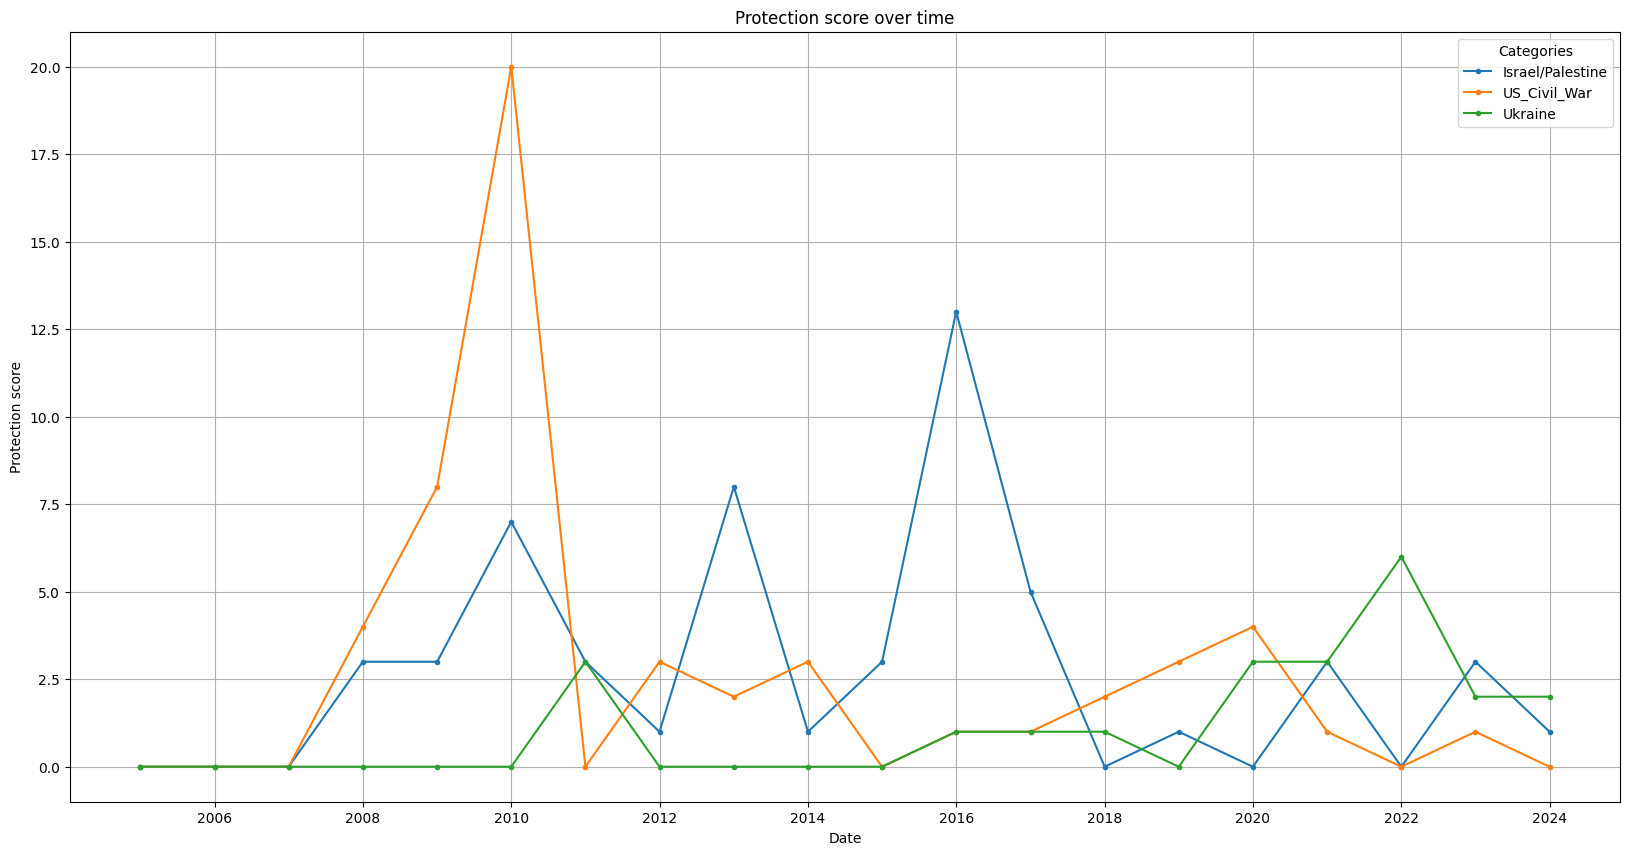

In [445]:
plot_protection(protections_df=protections_lengths_grouped, agg_col='length_protection', length_protection = 'Long', langs=['en'], group_by='topic')

In [374]:
agg_cols[['topic', 'article', 'language', 'date']].merge(protections_lengths[['topic', 'article', 'language', 'date', 'length_protection']], how='left', on=['topic', 'article', 'language', 'date']).dropna()

,topic,article,language,date,length_protection
404,Israel/Palestine,1929_Hebron_massacre,en,2007-04-01,Short
405,Israel/Palestine,1929_Hebron_massacre,en,2007-04-01,Short
411,Israel/Palestine,1929_Hebron_massacre,en,2007-10-01,Short
492,Israel/Palestine,1929_Hebron_massacre,en,2014-07-01,Short
549,Israel/Palestine,1929_Hebron_massacre,en,2019-04-01,Long
...,...,...,...,...,...
80859,Ukraine,Vyshyvanka,uk,2009-10-01,Long
81857,Ukraine,West_Ukrainian_People's_Republic,uk,2015-02-01,Short
82236,Ukraine,Zaporozhian_Cossacks,en,2008-02-01,Medium
82632,Ukraine,Zaporozhian_Cossacks,ru,2022-04-01,Short


In [373]:
agg_cols

,topic,article,language,date,edits,protected_time,protected_proportion
0,Israel/Palestine,1929_Hebron_massacre,ar,2007-07-01,6.0,0.0,0.0
1,Israel/Palestine,1929_Hebron_massacre,ar,2007-08-01,1.0,0.0,0.0
2,Israel/Palestine,1929_Hebron_massacre,ar,2007-09-01,0.0,0.0,0.0
3,Israel/Palestine,1929_Hebron_massacre,ar,2007-10-01,5.0,0.0,0.0
4,Israel/Palestine,1929_Hebron_massacre,ar,2007-11-01,0.0,0.0,0.0
...,...,...,...,...,...,...,...
82651,Ukraine,Zaporozhian_Cossacks,uk,2024-08-01,0.0,0.0,0.0
82652,Ukraine,Zaporozhian_Cossacks,uk,2024-09-01,0.0,0.0,0.0
82653,Ukraine,Zaporozhian_Cossacks,uk,2024-10-01,0.0,0.0,0.0
82654,Ukraine,Zaporozhian_Cossacks,uk,2024-11-01,0.0,0.0,0.0
